In [552]:
#!pip install --upgrade pip
#!pip install jpype1==1.0.2
#!pip install konlpy
#!pip install pipeline
#!pip install XGboost
#!pip install lightgbm
#!pip install catboost

In [1]:
import pandas as pd
import numpy as np
#시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

# 한글 표시
from konlpy.tag import Hannanum
#hannanum = Hannanum()
plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus = False)

import sys
import io
import glob

import re
import pipeline
import warnings
warnings.filterwarnings(action='ignore')

import time
from datetime import datetime,timedelta

In [451]:
# 전처리 함수

def word_pos_extract(text):
    text_pos = okt.pos(text, norm=True, stem=True, join=False)
    check_list = ["Verb","Noun","Adjective", "Foreign", 'Adverb']
    list = [c+"/"+tag for c,tag in text_pos if tag in check_list]
    return list

def preprocess_sentence_kr(w):
  w = w.strip()
  w = re.sub(r"[^0-9가-힣a-zA-Z?.!,¿]+", " ", w) # \n도 공백으로 대체해줌
  w = w.strip()
  return w

def extract_kr(w):
  w = w.strip()
  w = re.sub(r"[^가-힣]+", "", w) # \n도 공백으로 대체해줌
  w = w.strip()
  return w

## 1. 불용어 정의

In [118]:
words = open('Sentiment_Analysis/한국어불용어100 (2).txt', 'r', encoding='utf-8')

In [119]:
remove_list =[]
lines = words.readlines()
for line in lines:
    line = line.strip()
    remove_list.append(extract_kr(line))

In [120]:
add_list = ["것",'수','더','때','거','저','이','그','제','요','도','나','또','주','를','번','중','등','듯','안','의','분','알',
              '후','예','개','차','은', '걸','음','로','및', '뭐', '오','전','게','보','건', '가','다','싶','네']

for words in add_list:
    remove_list.append(words)

remove_list = pd.DataFrame({'단어':remove_list})
remove_list.to_csv('Sentiment_Analysis/불용어모음.txt', index=False)

In [2]:
remove_list = pd.read_csv('Sentiment_Analysis/불용어모음.txt')
remove_list = remove_list['단어'].to_list()

In [4]:
remove_list[:20]

['이',
 '있',
 '하',
 '것',
 '들',
 '그',
 '되',
 '수',
 '이',
 '보',
 '않',
 '없',
 '나',
 '사람',
 '주',
 '아니',
 '등',
 '같',
 '우리',
 '때']

## 2. Dataset 생성

In [131]:
data = pd.read_csv("C:/Users/midashrm/Documents/PythonWork/Sentiment_Analysis/성장전략서_1.csv", encoding='cp949')
data_1 = pd.read_csv('C:/Users/midashrm/Documents/PythonWork/Sentiment_Analysis/성장전략서_1q_ngram_leader_3grams_210629_3점완료_검수중.csv',encoding='cp949')
data_2 = pd.read_csv("C:/Users/midashrm/Documents/PythonWork/Sentiment_Analysis/성장전략서_6월_ngram_leader_3grams_sum_20210723_1차완료.csv", encoding='cp949')
data_3 = pd.read_csv("C:/Users/midashrm/Documents/PythonWork/Sentiment_Analysis/성장전략서_unique.csv", encoding='utf-8')


In [140]:
df_1 = data_1.copy()
df_2 = data_2.copy()
df_3 = data_3.copy()

In [141]:
df_1_words = df_1[df_1.columns.to_list()[-11:-1]]
df_1_words = df_1_words[df_1_words['비고(Y/N)'] =="Y"]
df_1_words.reset_index(drop=True, inplace=True)
df_1_words['word'] = df_1_words['word1']
df_1_words['word1'].fillna('-',inplace=True)
df_1_words['word2'].fillna('-',inplace=True)
df_1_words['word3'].fillna('-',inplace=True)
df_1_words['word'] = df_1_words['word1'] +" "+ df_1_words['word2'] +" "+ df_1_words['word3']
df_1_words['word'] = df_1_words['word'].astype('str').apply(preprocess_sentence_kr)
df_1_words.drop(['word1','word2','word3','비고(Y/N)'],axis=1,inplace=True)
df_1_words.columns = ['칭찬,인정','위로,공감','격려','태도코칭','전략코칭','업무','문장']
df_1_words = df_1_words[['문장','칭찬,인정','위로,공감','격려','태도코칭','전략코칭','업무']]
df_1_words

,문장,"칭찬,인정","위로,공감",격려,태도코칭,전략코칭,업무
0,6 개월 남짓,1,1,1,1.0,1.0,1.0
1,남짓 되는 기간,2,1,2,1.0,2.0,2.0
2,남짓 되는,2,1,2,1.0,2.0,2.0
3,되는 기간 동안,0,0,0,0.0,2.0,2.0
4,되는 기간,0,0,0,0.0,2.0,3.0
...,...,...,...,...,...,...,...
8838,내부 리뷰와 피드백이,0,0,0,0.0,1.0,0.0
8839,리뷰와 피드백이,0,0,0,0.0,1.0,0.0
8840,꼭 완료되기를 바랍니다,0,0,0,0.0,0.0,3.0
8841,완료되기를 바랍니다,0,0,0,0.0,0.0,3.0


In [142]:
df_2_words =  df_2[df_2.columns.to_list()[-10:]]
df_2_words = df_2_words[df_2_words['비고(Y/N)'] =="Y"]
df_2_words.reset_index(drop=True, inplace=True)
df_2_words['word'] = df_2_words['word1_T']
df_2_words['word1_T'].fillna('-',inplace=True)
df_2_words['word2_T'].fillna('-',inplace=True)
df_2_words['word3_T'].fillna('-',inplace=True)
df_2_words['word'] = df_2_words['word1_T'] +" "+ df_2_words['word2_T'] +" "+ df_2_words['word3_T']
df_2_words['word'] = df_2_words['word'].astype('str').apply(preprocess_sentence_kr)
df_2_words.drop(['word1_T','word2_T','word3_T','비고(Y/N)'],axis=1,inplace=True)
df_2_words.columns = ['칭찬,인정','위로,공감','격려','태도코칭','전략코칭','업무','문장']
df_2_words = df_2_words[['문장','칭찬,인정','위로,공감','격려','태도코칭','전략코칭','업무']]
df_2_words

,문장,"칭찬,인정","위로,공감",격려,태도코칭,전략코칭,업무
0,잘 부탁 드립니다,0,0,1,0,0,0
1,네 감사합니다,1,0,0,0,0,0
2,정리 잘 부탁,0,0,1,0,0,1
3,잘 부탁 드립니다,0,0,1,0,0,1
4,인수인계 준비도,0,0,1,0,0,1
...,...,...,...,...,...,...,...
5157,도움만 받고 있습니다,3,0,0,0,0,0
5158,집중력을 가지고,0,0,2,2,0,0
5159,가장빠른 성장을 하고계신,3,0,2,0,0,0
5160,가장빠른 성장을,3,0,2,0,0,0


In [143]:
df_3.columns = ['문장','칭찬,인정','위로,공감','격려','태도코칭','전략코칭','업무']
df_3

,문장,"칭찬,인정","위로,공감",격려,태도코칭,전략코칭,업무
0,"희용 따지고보면 6개월 남짓 되는 기간 동안 콜드콜 영업을 중점적으로 했을텐데, 개...",2,0,1,1.0,0.0,0.0
1,"희용 2월 대상 확보도 미리하고, MBM 기획, 방향 정도는 내가 말한 시간까지 2...",0,0,0,1.0,1.0,2.0
2,"희용 현재 건축에서 가장 많은 매출을 부담하고 있는데, 실제 결과로도 잘 보여주고 ...",2,0,1,0.0,0.0,0.0
3,희용 성장발표회 때 용근님의 모습은 과정을 상세하게 설명하는 특징을 보입니다. 상세...,2,0,1,0.0,0.0,0.0
4,희용 에이원구조기술사사무소 ADS 건을 팀원들과 공유하려 해주시고 벌써부터 다른 구...,2,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
3624,사람과의 관계보다 일을 통해 얻는 의미와 가치에 집중하면 좋겠음. 나 역시 사람때문...,0,0,2,2.0,0.0,0.0
3625,4월말 IM의 내부 리뷰와 피드백이 꼭 완료되기를 바랍니다.,0,0,0,0.0,0.0,3.0
3626,누구보다도 이번 행사의 중요성과 책임을 느끼고 있습니다. 아직까지 영역별 담당자와 ...,2,0,2,0.0,0.0,0.0
3627,"세상에서 가장 중요한 2개의 날이 있습니다. 하나는 태어난 날이고, 다른 하나는 태...",0,0,2,1.0,0.0,0.0


In [144]:
concat = pd.concat([df_1_words,df_2_words,df_3])

In [145]:
# 데이터 전처리 함수 적용
concat['문장'] = concat['문장'].astype("str").apply(preprocess_sentence_kr)

In [146]:
# 최종 훈련데이터
df

,문장,"칭찬,인정","위로,공감",격려,태도코칭,전략코칭,업무
0,6 개월 남짓,1,1,1,1.0,1.0,1.0
1,남짓 되는 기간,2,1,2,1.0,2.0,2.0
2,남짓 되는,2,1,2,1.0,2.0,2.0
3,되는 기간 동안,0,0,0,0.0,2.0,2.0
4,되는 기간,0,0,0,0.0,2.0,3.0
...,...,...,...,...,...,...,...
17629,사람과의 관계보다 일을 통해 얻는 의미와 가치에 집중하면 좋겠음. 나 역시 사람때문...,0,0,2,2.0,0.0,0.0
17630,4월말 IM의 내부 리뷰와 피드백이 꼭 완료되기를 바랍니다.,0,0,0,0.0,0.0,3.0
17631,누구보다도 이번 행사의 중요성과 책임을 느끼고 있습니다. 아직까지 영역별 담당자와 ...,2,0,2,0.0,0.0,0.0
17632,"세상에서 가장 중요한 2개의 날이 있습니다. 하나는 태어난 날이고, 다른 하나는 태...",0,0,2,1.0,0.0,0.0


In [459]:
df.to_csv("C:/Users/midashrm/Documents/PythonWork/Sentiment_Analysis/성장전략서_words.csv", encoding='utf-8',index=False)

## 3. Data 불러오기 , 전처리 후 새로 저장

In [453]:
data = pd.read_csv("C:/Users/midashrm/Documents/PythonWork/Sentiment_Analysis/성장전략서_words.csv", encoding='utf-8')
df = data.copy()
df.info()
# 열마다 데이터 갯수가 다름, 문장 포함 결측치행 삭제, 라벨링 결측치'0'으로 교체

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17634 entries, 0 to 17633
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   문장      17626 non-null  object 
 1   칭찬,인정   17634 non-null  int64  
 2   위로,공감   17634 non-null  object 
 3   격려      17634 non-null  int64  
 4   태도코칭    17634 non-null  float64
 5   전략코칭    17634 non-null  float64
 6   업무      17634 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 964.5+ KB


In [454]:
df = df[df['문장'].notnull()]
df['칭찬,인정'].fillna('0',inplace=True)
df['위로,공감'].fillna('0',inplace=True)
df['위로,공감'].replace(" ",'0',inplace=True) # 해당 행에만 " "이 있어 0으로 대체
df['격려'].fillna('0',inplace=True)
df['태도코칭'].fillna('0',inplace=True)
df['전략코칭'].fillna('0',inplace=True)
df['업무'].fillna('0',inplace=True)
df.reset_index(drop=True,inplace=True)

In [455]:
df.to_csv("C:/Users/midashrm/Documents/PythonWork/Sentiment_Analysis/성장전략서_words.csv", encoding='utf-8',index=False)
df.to_csv("C:/Users/midashrm/Documents/PythonWork/Sentiment_Analysis/성장전략서_words_1.csv", encoding='euc kr',index=False)

### 3-1. 문장 기본형으로 교체 후 벡터화(TF-IDF벡터화 이용)

In [151]:
from konlpy.tag import Okt
okt = Okt()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

In [154]:
# 기본형 교체 함수

def word_extract(text):
    text = text.strip()
    text = re.sub(r"[^0-9가-힣a-zA-Z?.!,¿]+", " ", text) # \n도 공백으로 대체해줌
    text = text.strip()
    text_pos = okt.pos(text, norm=True, stem=True, join=False)
    check_list = ["Verb","Noun","Adjective",'Foreign','Adverb'] # 동사, 명사, 형용사, 부사, 외국어, 부사
    list = [c for c,tag in text_pos if tag in check_list]
    word = [i.split('/')[0] for i in list]
    word = [x for x in word if x not in remove_list]
    return word

In [112]:
# 표준화 
std_word = df['문장'].apply(word_extract)
std_word[0:20]

0                [개월, 남짓]
1            [남짓, 되다, 기간]
2                [남짓, 되다]
3            [되다, 기간, 동안]
4                [되다, 기간]
5                [기간, 동안]
6         [콜드, 콜, 영업, 중점]
7             [콜드, 콜, 영업]
8            [영업, 중점, 하다]
9                [영업, 중점]
10               [중점, 하다]
11      [개선, 스스로, 파악, 하다]
12              [개선, 스스로]
13    [스스로, 파악, 하다, 나아가다]
14          [스스로, 파악, 하다]
15     [파악, 하다, 나아가다, 과정]
16         [파악, 하다, 나아가다]
17         [나아가다, 과정, 하다]
18             [나아가다, 과정]
19               [과정, 하다]
Name: 문장, dtype: object

In [158]:
tf_idf_vect = TfidfVectorizer(dtype=np.float32, tokenizer = lambda x:word_extract(x),ngram_range = (1, 2)) # 1그램 ~ 2그램으로 분리
bow_vect = tf_idf_vect.fit_transform(df['문장'].tolist())

In [206]:
bow_vect.shape

(17626, 51352)

17626 문장에서 51352 단어 그램이 만들어짐

In [115]:
bow_vect.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [116]:
# 단어 리스트
word_list = tf_idf_vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis=0)
word_list[0:40]

['가가',
 '가가 명확하다',
 '가게',
 '가게 되다',
 '가격',
 '가격 고',
 '가격 정책',
 '가격 항목',
 '가격표',
 '가격표 소개',
 '가격표 작업',
 '가급적',
 '가급적 법카',
 '가급적 사전',
 '가급적 함께',
 '가기',
 '가기 위',
 '가까워지다',
 '가까워지다 자기',
 '가까이',
 '가까이 보다',
 '가까이 상황',
 '가까이 팀',
 '가까이 하다',
 '가까이 함께',
 '가깝다',
 '가깝다 이야기',
 '가깝다 질',
 '가끔',
 '가끔 기술',
 '가끔 깜짝',
 '가끔 나다',
 '가끔 날다',
 '가끔 너무',
 '가끔 듣다',
 '가끔 물어보다',
 '가끔 본인',
 '가끔 쓰시',
 '가끔 아침',
 '가끔 엄청']

In [117]:
invert_index_vectorizer = {v: k for k, v in tf_idf_vect.vocabulary_.items()}
print(str(invert_index_vectorizer)[:100]+'...')

{2107: '개월', 8351: '남짓', 2109: '개월 남짓', 12268: '되다', 6241: '기간', 8352: '남짓 되다', 12324: '되다 기간', 1211...


In [118]:
# 단어 중요도
word_count_dict = list(zip(word_list, count_list))
word_count_dict[0:40]

[('가가', 0.1137306),
 ('가가 명확하다', 0.1137306),
 ('가게', 0.11771185),
 ('가게 되다', 0.11771185),
 ('가격', 0.4534798),
 ('가격 고', 0.23204492),
 ('가격 정책', 0.13623449),
 ('가격 항목', 0.11867195),
 ('가격표', 0.31342995),
 ('가격표 소개', 0.16077185),
 ('가격표 작업', 0.16578864),
 ('가급적', 0.4063912),
 ('가급적 법카', 0.12846828),
 ('가급적 사전', 0.124284856),
 ('가급적 함께', 0.18363404),
 ('가기', 0.16578864),
 ('가기 위', 0.16578864),
 ('가까워지다', 0.15839788),
 ('가까워지다 자기', 0.15839788),
 ('가까이', 0.77006245),
 ('가까이 보다', 0.22100522),
 ('가까이 상황', 0.21186118),
 ('가까이 팀', 0.08221641),
 ('가까이 하다', 0.15261419),
 ('가까이 함께', 0.19651781),
 ('가깝다', 0.63532084),
 ('가깝다 이야기', 0.03487133),
 ('가깝다 질', 0.61831015),
 ('가끔', 2.1367884),
 ('가끔 기술', 0.1803034),
 ('가끔 깜짝', 0.095008455),
 ('가끔 나다', 0.16652386),
 ('가끔 날다', 0.6356266),
 ('가끔 너무', 0.07435476),
 ('가끔 듣다', 0.30314344),
 ('가끔 물어보다', 0.329007),
 ('가끔 본인', 0.08466667),
 ('가끔 쓰시', 0.12846828),
 ('가끔 아침', 0.04846525),
 ('가끔 엄청', 0.082564674)]

## 4. 최적 모델 선정

In [458]:
# 함수 목록

def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    Train_accuracy = accuracy_score(y_train, y_train_pred)
    Test_accuracy = accuracy_score(y_test, y_test_pred)
    Test_F1_Score = f1_score(y_test, y_test_pred, average='weighted')
    print('Train_accuracy: %.3f' % Train_accuracy)
    print('Test_accuracy: %.3f' % Test_accuracy)
    print('F1_Weighted_Score: %.3f' % Test_F1_Score)
    
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

### 4-1. 데이터 정의 및 split 진행

In [273]:
feature = bow_vect

# 각 라벨 int타입으로 종속변수로 지정
y_칭찬_인정 = df['칭찬,인정'].astype('int64')
y_위로_공감 = df['위로,공감'].astype('int64')
y_격려 = df['격려'].astype('int64')
y_태도코칭 = df['태도코칭'].astype('int64')
y_전략코칭 = df['전략코칭'].astype('int64')
y_업무 = df['업무'].astype('int64')

model_list = ["Logistic Regression", "SVM", "Naive-Bayes", 'XGBoost','LightGBM'] # 정확도를 측정할 모델 리스트
test_accuracy = []
f1 = []
train_accuracy = []
runtime = []

### 4-2. 각 라벨별 f1_score가 가장 높은 모델 찾기(기본형)
* 라벨별 점수의 분포가 불균등(imbalanced) 하기 때문에 f1-score의 weighted averge를 주요 지표로 삼음

In [174]:
# 모델 불러오기
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import naive_bayes
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import minmax_scale

def Score_per_label(feature,y):
    
    X_train, X_test, y_train, y_test = train_test_split(feature, y, test_size = 0.3, random_state=42)
    Test_Accuracy = []
    F1_weighted_Score = []
    runtime = []
    model_list = ["LogisticRegression", "SVM","Naive-Bayes", "XGBoost", "LightGBM"]
    models = [LogisticRegression(),svm.SVC(kernel='linear'),naive_bayes.MultinomialNB(),XGBClassifier(eval_metric='mlogloss'),LGBMClassifier()]
    
    for model in models:
        start_time = time.time() 
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        f1_weighted = f1_score(y_test, y_test_pred, average='weighted')        
        Test_accuracy = accuracy_score(y_test, y_test_pred)
        
        run_time = time.time() - start_time
        
        print(model,'->',"Test_Accuracy:",Test_accuracy,"F1_weighted_Score:",f1_weighted,"runtime:",run_time)
        
        F1_weighted_Score.append(round(f1_weighted,3))        
        Test_Accuracy.append(round(Test_accuracy,3))
        runtime.append(run_time)
        
    Score_y = pd.DataFrame({"Test_Accuracy":Test_Accuracy,"F1_weighted_Score": F1_weighted_Score, "Runtime": minmax_scale(runtime, axis=0) }, index=model_list)
    Score_y['Runtime'] = round(Score_y['Runtime'],3)
    return Score_y

In [175]:
y_칭찬_인정_score = Score_per_label(bow_vect,y_칭찬_인정)
y_위로_공감_score = Score_per_label(bow_vect,y_위로_공감)
y_격려_score = Score_per_label(bow_vect,y_격려)
y_태도코칭_score = Score_per_label(bow_vect,y_태도코칭)
y_전략코칭_score = Score_per_label(bow_vect,y_전략코칭)
y_업무_score = Score_per_label(bow_vect,y_업무)

LogisticRegression() -> Test_Accuracy: 0.7726928895612708 F1_weighted_Score: 0.725318752015282 runtime: 5.492062568664551
SVC(kernel='linear') -> Test_Accuracy: 0.789712556732224 F1_weighted_Score: 0.754801167877517 runtime: 25.893784523010254
MultinomialNB() -> Test_Accuracy: 0.7326021180030258 F1_weighted_Score: 0.6412147172913337 runtime: 0.015619993209838867
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, 

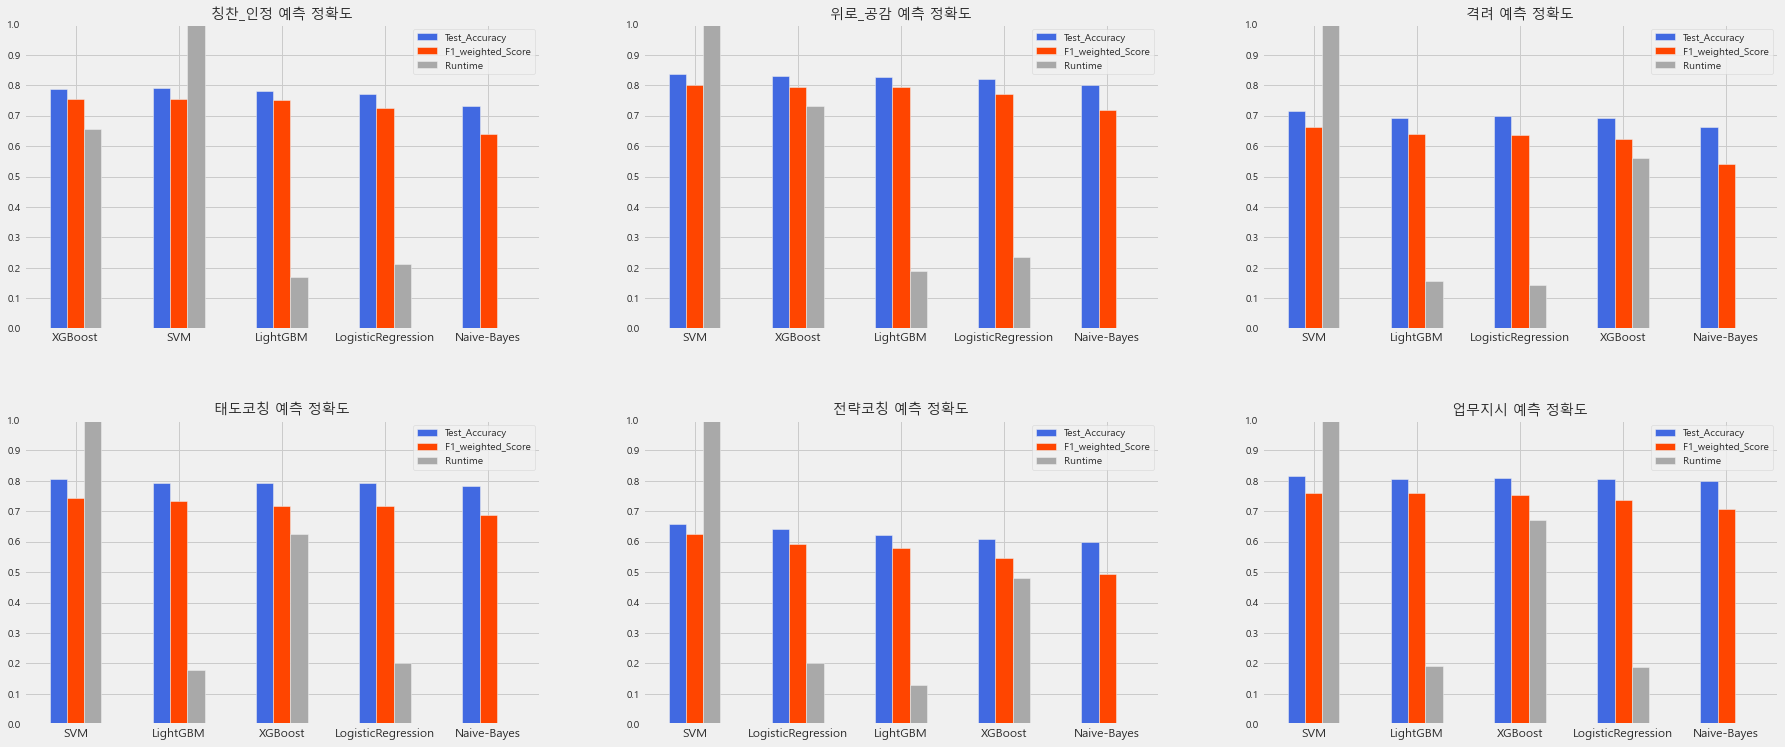

In [176]:
parameters = {'xtick.labelsize': 12, 'ytick.labelsize': 10, 'legend.fontsize': 10}
plt.rcParams.update(parameters)
 
f,ax=plt.subplots(2,3,figsize=(28,12))

fig = y_칭찬_인정_score.sort_values(by='F1_weighted_Score',ascending=False).plot(kind='bar', rot=0,ylim = [0,1], ax=ax[0,0],color=['royalblue','orangered','darkgrey'])
ax[0,0].set_yticks(np.arange(0,1.1,0.1))
ax[0,0].set_title('칭찬_인정 예측 정확도',fontsize=14)

fig = y_위로_공감_score.sort_values(by='F1_weighted_Score',ascending=False).plot(kind='bar', rot=0, ylim = [0,1], ax=ax[0,1],color=['royalblue','orangered','darkgrey'])   
ax[0,1].set_yticks(np.arange(0,1.1,0.1))
ax[0,1].set_title('위로_공감 예측 정확도',fontsize=14)

fig = y_격려_score.sort_values(by='F1_weighted_Score',ascending=False).plot(kind='bar', rot=0, ylim = [0,1], ax=ax[0,2],color=['royalblue','orangered','darkgrey'])
ax[0,2].set_yticks(np.arange(0,1.1,0.1))
ax[0,2].set_title('격려 예측 정확도',fontsize=14)

fig = y_태도코칭_score.sort_values(by='F1_weighted_Score',ascending=False).plot(kind='bar', rot=0, ylim = [0,1], ax=ax[1,0],color=['royalblue','orangered','darkgrey'])
ax[1,0].set_yticks(np.arange(0,1.1,0.1))
ax[1,0].set_title('태도코칭 예측 정확도',fontsize=14)

fig = y_전략코칭_score.sort_values(by='F1_weighted_Score',ascending=False).plot(kind='bar',rot=0, ylim = [0,1], ax=ax[1,1],color=['royalblue','orangered','darkgrey'])
ax[1,1].set_yticks(np.arange(0,1.1,0.1))
ax[1,1].set_title('전략코칭 예측 정확도',fontsize=14)

fig = y_업무_score.sort_values(by='F1_weighted_Score',ascending=False).plot(kind='bar', rot=0, ylim = [0,1], ax=ax[1,2],color=['royalblue','orangered','darkgrey'])
ax[1,2].set_yticks(np.arange(0,1.1,0.1))
ax[1,2].set_title('업무지시 예측 정확도',fontsize=14)

plt.subplots_adjust(hspace=0.3,wspace=0.2)
plt.show()

#### F1_weighted_score, Runtime을 고려하여 라벨 별 상이한 모델 선정

- 칭찬_인정: XGBoost
- 위로_공감: XGBoost
- 격려: SVM
- 태도코칭: LightGBM
- 전략코칭: SVM
- 업무지시: LightGBM

In [415]:
Target = ['칭찬_인정','위로_공감','격려','태도코칭','전략코칭','업무지시']
Basic_F1_Score = [y_칭찬_인정_score.loc["XGBoost","F1_weighted_Score"],y_위로_공감_score.loc["XGBoost","F1_weighted_Score"],y_격려_score.loc["SVM","F1_weighted_Score"]
                   ,y_태도코칭_score.loc["LightGBM","F1_weighted_Score"],y_전략코칭_score.loc["SVM","F1_weighted_Score"],y_업무_score.loc["LightGBM","F1_weighted_Score"]]

([<matplotlib.axis.YTick at 0x1cabcf4ff70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

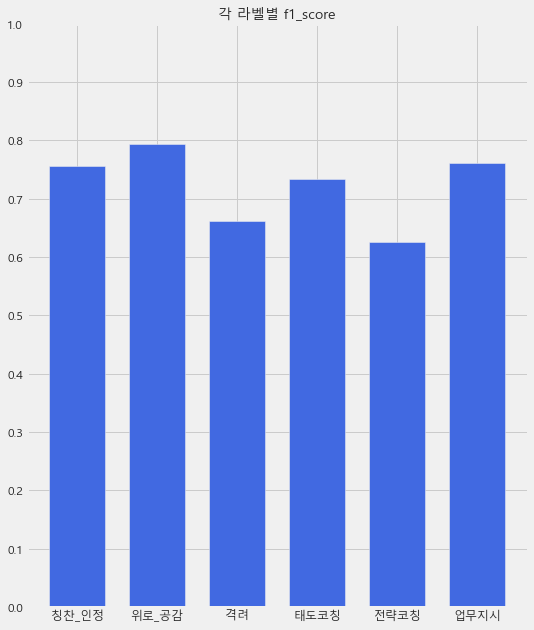

In [439]:
plt.figure(figsize=(8,10))
plt.bar(x = Target, height=Basic_F1_Score, color='royalblue', width=0.7)
plt.title("각 라벨별 f1_score", fontsize=14)
plt.ylim(0,1.0)
plt.yticks(np.arange(0,1.1,0.1))

### 4-3. 라벨별 파라미터 튜닝

#### ※ 파라미터 List
    
    1) n_estimators : 반복 수행하는 트리의 개수를 의미함.
    2) learning_rate : 최종 결과에 대한 각각의 Tree에 영향을 미치는 변수를 추정한 후 추정에서 발생하는 변화의 크기를 컨트롤함
    3) min_child_weight : 트리에서 추가적으로 가지를 나눌 지 경정하기 위해 필요한 데이터들의 가중치 총합, 과적합 제어
    4) subsample : 과적합을 제어하기 위해 데이터를 샘플링하는 비율을 의미함
    5) colsample_bytree : 개별 트리를 학습할 때마다 무작위로 선택하는 피쳐의 비율을 제어한다, 과적합 제어
    6) max_depth : Tree의 최대 깊이, 일반적으로 과적합 해결을 위해 이용

In [421]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import naive_bayes
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import minmax_scale

Tuned_Test_Score= []

#### 1) y_칭찬_인정_score(XGBoost)

In [270]:
y_칭찬_인정_score.loc["XGBoost"]

Test_Accuracy        0.787
F1_weighted_Score    0.756
Runtime              0.656
Name: XGBoost, dtype: float64

In [422]:
## train, test 데이터 나누기(칭찬,인정 먼저 진행)
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(feature, y_칭찬_인정, test_size = 0.3, random_state=42)

In [323]:
# 기본형
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric = 'mlogloss')
xgb.fit(X_train,y_train)

# 분류 결과 스코어
evaluate(xgb,X_train, X_test, y_train, y_test)

Train_accuracy: 0.849
Test_accuracy: 0.787
F1_Weighted_Score: 0.756


In [324]:
# 파라미터 튜닝
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

params = {
        'max_depth': range(3,10,2),
        'min_child_weight': range(1,10,2),
        'gamma': [i/10.0 for i in range(0,5)],
        'subsample':[i/10.0 for i in range(6,10)],
        'colsample_bytree':[i/10.0 for i in range(6,10)],
        'learning_rate':[1, 0.5, 0.1, 0.01, 0.05],
       }


folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='f1_weighted', 
                                   n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=42 )

start_time = timer(None)
random_search.fit(X_train, y_train)
timer(start_time)

print('최적 하이퍼 파라미터:{0}'.format(random_search.best_params_))

Fitting 3 folds for each of 5 candidates, totalling 15 fits

 Time taken: 0 hours 2 minutes and 43.66 seconds.
최적 하이퍼 파라미터:{'subsample': 0.9, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 1, 'gamma': 0.4, 'colsample_bytree': 0.9}


In [423]:
from xgboost import XGBClassifier

xgb = XGBClassifier(subsample =0.9, min_child_weight=1, max_depth=3,learning_rate=1,
                    gamma=0.4, colsample_bytree=0.9, eval_metric = 'mlogloss')

xgb.fit(X_train,y_train)
y_test_pred = xgb.predict(X_test)

# 분류 결과 스코어
evaluate(xgb,X_train, X_test, y_train, y_test)
Tuned_Test_Score.append(f1_score(y_test, y_test_pred, average='weighted'))

Train_accuracy: 0.865
Test_accuracy: 0.784
F1_Weighted_Score: 0.758


#### 2) y_위로_공감_score(XGBoost)

In [326]:
y_위로_공감_score.loc["XGBoost"]

Test_Accuracy        0.829
F1_weighted_Score    0.794
Runtime              0.733
Name: XGBoost, dtype: float64

In [424]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(feature, y_위로_공감, test_size = 0.3, random_state=42)

In [328]:
# 기본형
from xgboost import XGBClassifier

xgb = XGBClassifier(eval_metric = 'mlogloss')
xgb.fit(X_train,y_train)

# 분류 결과 스코어
evaluate(xgb,X_train, X_test, y_train, y_test)

Train_accuracy: 0.894
Test_accuracy: 0.829
F1_Weighted_Score: 0.794


In [329]:
# 파라미터 튜닝
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

params = {
        'max_depth': range(3,10,2),
        'min_child_weight': range(1,10,2),
        'gamma': [i/10.0 for i in range(0,5)],
        'subsample':[i/10.0 for i in range(6,10)],
        'colsample_bytree':[i/10.0 for i in range(6,10)],
        'learning_rate':[1, 0.5, 0.1, 0.01, 0.05],
       }


folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='f1_weighted', 
                                   n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=42 )

start_time = timer(None)
random_search.fit(X_train, y_train)
timer(start_time)

print('최적 하이퍼 파라미터:{0}'.format(random_search.best_params_))

Fitting 3 folds for each of 5 candidates, totalling 15 fits

 Time taken: 0 hours 2 minutes and 40.08 seconds.
최적 하이퍼 파라미터:{'subsample': 0.9, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 1, 'gamma': 0.4, 'colsample_bytree': 0.9}


In [425]:
from xgboost import XGBClassifier

xgb = XGBClassifier(subsample =0.9, min_child_weight= 1, max_depth= 3,learning_rate = 1,
                    gamma=0.4, colsample_bytree=0.9, eval_metric = 'mlogloss')

xgb.fit(X_train,y_train)
y_test_pred = xgb.predict(X_test)

# 분류 결과 스코어
evaluate(xgb,X_train, X_test, y_train, y_test)
Tuned_Test_Score.append(f1_score(y_test, y_test_pred, average='weighted'))

Train_accuracy: 0.905
Test_accuracy: 0.824
F1_Weighted_Score: 0.798


#### 3) y_격려_score(SVM)

In [414]:
y_격려_score.loc["SVM"]

Test_Accuracy        0.714
F1_weighted_Score    0.662
Runtime              1.000
Name: SVM, dtype: float64

In [426]:
from sklearn.model_selection import train_test_split, StratifiedKFold
X_train, X_test, y_train, y_test = train_test_split(feature, y_격려, test_size = 0.3, random_state=42)

In [418]:
# 기본형
from sklearn import svm

svm = svm.SVC(kernel='linear')
svm.fit(X_train,y_train)

# 분류 결과 스코어
evaluate(svm,X_train, X_test, y_train, y_test)

Train_accuracy: 0.845
Test_accuracy: 0.714
F1_Weighted_Score: 0.662


In [419]:
# 파라미터 튜닝
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

params = {
        'C': [0.1, 1, 10, 100, 1000], 
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
        }

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(svm, param_distributions=params, n_iter=param_comb, scoring='f1_weighted', 
                                   n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=42)

start_time = timer(None)
random_search.fit(X_train, y_train)
timer(start_time)

print('최적 하이퍼 파라미터:{0}'.format(random_search.best_params_))

Fitting 3 folds for each of 5 candidates, totalling 15 fits

 Time taken: 0 hours 3 minutes and 24.37 seconds.
최적 하이퍼 파라미터:{'gamma': 0.1, 'C': 10}


In [427]:
from sklearn import svm
svm = svm.SVC(kernel='linear', gamma=0.1, C=10)

svm.fit(X_train,y_train)
y_test_pred = svm.predict(X_test)

# 분류 결과 스코어
evaluate(svm,X_train, X_test, y_train, y_test)
Tuned_Test_Score.append(f1_score(y_test, y_test_pred, average='weighted'))

Train_accuracy: 0.950
Test_accuracy: 0.710
F1_Weighted_Score: 0.687


#### 4) y_태도코칭_score(LightGBM)

In [340]:
y_태도코칭_score.loc["LightGBM"]

Test_Accuracy        0.793
F1_weighted_Score    0.733
Runtime              0.177
Name: LightGBM, dtype: float64

In [428]:
from sklearn.model_selection import train_test_split, StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(feature, y_태도코칭, test_size = 0.3, random_state=42)

In [342]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(objective ='multiclass:4', metric="multiclass")
lgbm.fit(X_train,y_train)

# 분류 결과 스코어
evaluate(lgbm,X_train, X_test, y_train, y_test)

Train_accuracy: 0.851
Test_accuracy: 0.793
F1_Weighted_Score: 0.733


In [343]:
# 파라미터 튜닝
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

params = {
        'n_estimators' : range(0,800,50),
        'max_depth': range(1,10,2),
        'min_child_weight': range(1,10,2),
        'subsample':[i/10.0 for i in range(6,10)],
        'colsample_bytree':[i/10.0 for i in range(6,10)],
        'learning_rate':[1, 0.5, 0.1, 0.01, 0.05],
        }

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(lgbm, param_distributions=params, n_iter=param_comb, scoring='f1_weighted', 
                                   n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=42)

start_time = timer(None)
random_search.fit(X_train, y_train)
timer(start_time)

print('최적 하이퍼 파라미터:{0}'.format(random_search.best_params_))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Warning] Unknown parameter: gamma

 Time taken: 0 hours 0 minutes and 55.17 seconds.
최적 하이퍼 파라미터:{'subsample': 0.8, 'n_estimators': 750, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.5, 'gamma': 0.3, 'colsample_bytree': 0.6}


In [429]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(subsample = 0.8, n_estimators = 750, min_child_weight = 3, max_depth = 9, learning_rate = 0.5, 
                      gamma = 0.3, colsample_bytree = 0.6, metric="multiclass")
lgbm.fit(X_train,y_train)
y_test_pred = lgbm.predict(X_test)

# 분류 결과 스코어
evaluate(lgbm,X_train, X_test, y_train, y_test)
Tuned_Test_Score.append(f1_score(y_test, y_test_pred, average='weighted'))

[LightGBM] [Warning] Unknown parameter: gamma
Train_accuracy: 0.920
Test_accuracy: 0.775
F1_Weighted_Score: 0.737


#### 5) y_전략코칭_score(SVM)

In [346]:
y_전략코칭_score.loc["SVM"]

Test_Accuracy        0.658
F1_weighted_Score    0.626
Runtime              1.000
Name: SVM, dtype: float64

In [430]:
from sklearn.model_selection import train_test_split, StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(feature, y_전략코칭, test_size = 0.3, random_state=42)

In [348]:
from sklearn import svm


svm = svm.SVC(kernel='linear')
svm.fit(X_train,y_train)

# 분류 결과 스코어
evaluate(svm,X_train, X_test, y_train, y_test)

Train_accuracy: 0.858
Test_accuracy: 0.658
F1_Weighted_Score: 0.626


In [349]:
# 파라미터 튜닝
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

params = {
        'C': [0.1, 1, 10, 100, 1000], 
        'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
        }

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(svm, param_distributions=params, n_iter=param_comb, scoring='f1_weighted', 
                                   n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=42)

start_time = timer(None)
random_search.fit(X_train, y_train)
timer(start_time)

print('최적 하이퍼 파라미터:{0}'.format(random_search.best_params_))

Fitting 3 folds for each of 5 candidates, totalling 15 fits

 Time taken: 0 hours 1 minutes and 53.05 seconds.
최적 하이퍼 파라미터:{'gamma': 0.1, 'C': 10}


In [431]:
from sklearn import svm
svm = svm.SVC(kernel='linear', gamma=0.1, C=10)

svm.fit(X_train,y_train)
y_test_pred = svm.predict(X_test)

# 분류 결과 스코어
evaluate(svm,X_train, X_test, y_train, y_test)
Tuned_Test_Score.append(f1_score(y_test, y_test_pred, average='weighted'))

Train_accuracy: 0.953
Test_accuracy: 0.640
F1_Weighted_Score: 0.633


#### 6) y_업무지시_score(LightGBM)

In [352]:
y_업무_score.loc["LightGBM"]

Test_Accuracy        0.807
F1_weighted_Score    0.761
Runtime              0.191
Name: LightGBM, dtype: float64

In [432]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(feature, y_업무, test_size = 0.3, random_state=42)

In [362]:
from lightgbm import LGBMClassifier

# 학습
lgbm = LGBMClassifier(objective ='multiclass:4', metric="multiclass")
lgbm.fit(X_train, y_train)

# 분류 결과 스코어

evaluate(lgbm,X_train, X_test, y_train, y_test)

Train_accuracy: 0.885
Test_accuracy: 0.807
F1_Weighted_Score: 0.761


In [363]:
# 파라미터 튜닝
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

params = {
        'n_estimators' : range(0,800,50),
        'max_depth': range(1,10,2),
        'min_child_weight': range(1,10,2),
        'subsample':[i/10.0 for i in range(6,10)],
        'colsample_bytree':[i/10.0 for i in range(6,10)],
        'learning_rate':[1, 0.5, 0.1, 0.01, 0.05],
        }

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(lgbm, param_distributions=params, n_iter=param_comb, scoring='f1_weighted', 
                                   n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=42)

start_time = timer(None)
random_search.fit(X_train, y_train)
timer(start_time)

print('최적 하이퍼 파라미터:{0}'.format(random_search.best_params_))

Fitting 3 folds for each of 5 candidates, totalling 15 fits

 Time taken: 0 hours 0 minutes and 47.42 seconds.
최적 하이퍼 파라미터:{'subsample': 0.9, 'n_estimators': 600, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.7}


In [433]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(subsample = 0.9, n_estimators = 600, min_child_weight = 3, max_depth = 9, learning_rate = 0.05, 
                      colsample_bytree = 0.7, metric="multiclass")
lgbm.fit(X_train,y_train)
y_test_pred = lgbm.predict(X_test)

# 분류 결과 스코어
evaluate(lgbm,X_train, X_test, y_train, y_test)
Tuned_Test_Score.append(f1_score(y_test, y_test_pred, average='weighted'))

Train_accuracy: 0.878
Test_accuracy: 0.807
F1_Weighted_Score: 0.763


In [435]:
Label_Score = pd.DataFrame({"Basic_F1_Score":Basic_F1_Score, "Tuned_F1_Score":Tuned_Test_Score}, index = Target)
Label_Score['Tuned_F1_Score'] = round(Label_Score['Tuned_F1_Score'],3)
Label_Score

,Basic_F1_Score,Tuned_F1_Score
칭찬_인정,0.756,0.758
위로_공감,0.794,0.798
격려,0.662,0.687
태도코칭,0.733,0.737
전략코칭,0.626,0.633
업무지시,0.761,0.763


([<matplotlib.axis.YTick at 0x1caa77a1580>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

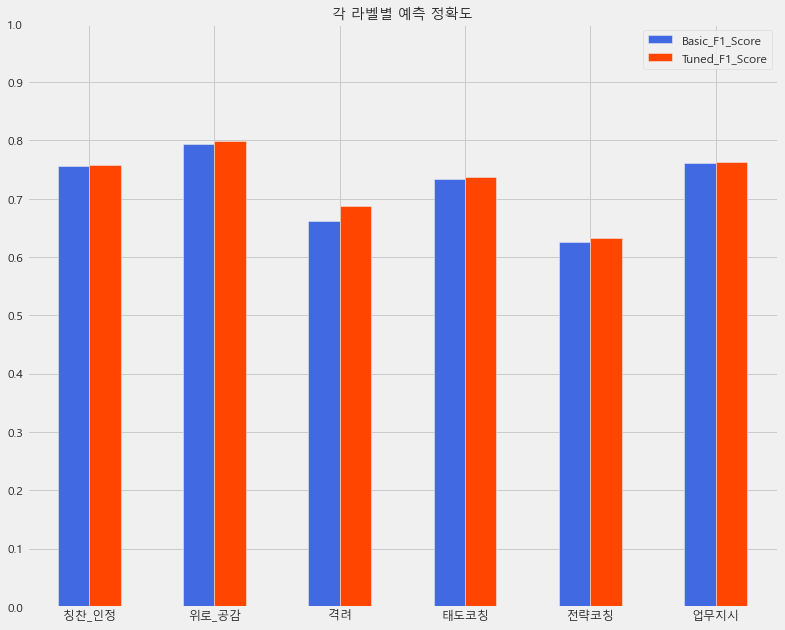

In [436]:
parameters = {'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 12}
plt.rcParams.update(parameters)
fig = Label_Score.plot(kind='bar', figsize=(12,10), ylim=[0,1.0],color =['royalblue','orangered'])
plt.title("각 라벨별 예측 정확도", fontsize=14)
plt.xticks(rotation=0)
plt.yticks(np.arange(0,1.1,0.1))

파라미터 튜닝을 했음에도 격려, 전략코칭의 경우 정확도가 70%에 미치지 못하여 차후 훈련데이터 추가등의 조치가 필요함

## 5. 새로운 dataframe에 적용 모델

In [468]:
# 훈련 데이터 불러오기
data = pd.read_csv("C:/Users/midashrm/Documents/PythonWork/Sentiment_Analysis/성장전략서_words.csv", encoding='utf-8')
df = data.copy()

feature = bow_vect
y_칭찬_인정 = df['칭찬,인정'].astype('int64')
y_위로_공감 = df['위로,공감'].astype('int64')
y_격려 = df['격려'].astype('int64')
y_태도코칭 = df['태도코칭'].astype('int64')
y_전략코칭 = df['전략코칭'].astype('int64')
y_업무 = df['업무'].astype('int64')

In [469]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from konlpy.tag import Okt,Komoran
okt = Okt()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn import svm

# 예측 모델 함수
def predict_model(data, word): #data: 훈련 데이터, word: 새로운 데이터(시리즈 형태로 입력)
    
    # 학습 데이터 불러오기 
    start_time = timer(None)

    # 결측치 처리
    df = data.copy()
    df = df[df['문장'].notnull()]
    df['칭찬,인정'].fillna('0',inplace=True)
    df['위로,공감'].fillna('0',inplace=True)
    df['위로,공감'].replace(" ",'0',inplace=True) 
    df['격려'].fillna('0',inplace=True)
    df['태도코칭'].fillna('0',inplace=True)
    df['전략코칭'].fillna('0',inplace=True)
    df['업무'].fillna('0',inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    # 학습 데이터 벡터화
    tf_idf_vect = TfidfVectorizer(dtype=np.float32, tokenizer = lambda x:word_extract(x),ngram_range = (1, 2))
    bow_vect = tf_idf_vect.fit_transform(df['문장'].tolist())
    feature = bow_vect
    print("훈련 데이터 벡터화 완료")
    
    # 타겟 변수 설정
    y_칭찬_인정 = df['칭찬,인정'].astype('int64')
    y_위로_공감 = df['위로,공감'].astype('int64')
    y_격려 = df['격려'].astype('int64')
    y_태도코칭 = df['태도코칭'].astype('int64')
    y_전략코칭 = df['전략코칭'].astype('int64')
    y_업무 = df['업무'].astype('int64')
    
    # 예측 할 Data 전처리 및 벡터화(시리즈 형식의 데이터 형태로 입력)
    word.dropna(axis=0,inplace=True)
    new_word = tf_idf_vect.transform(word.to_list())
    pred = pd.DataFrame(word)  
    print("새로운 데이터 벡터화 완료")
    
    ## 칭찬_인정 예측
    X_train, X_test, y_train, y_test = train_test_split(feature,y_칭찬_인정,test_size=0.3,random_state=42)
    xgb_칭찬 = XGBClassifier(subsample =0.9, min_child_weight=1, max_depth=3,learning_rate=1,
                gamma=0.4, colsample_bytree=0.9, eval_metric = 'mlogloss')
    
    xgb_칭찬.fit(X_train, y_train)
    pred['칭찬_인정'] = xgb_칭찬.predict(new_word)
    print("칭찬_인정 완료")
    
    ## 위로_공감 예측
    X_train, X_test, y_train, y_test = train_test_split(feature,y_위로_공감,test_size=0.3,random_state=42)
    xgb_위로 = XGBClassifier(subsample =0.9, min_child_weight= 1, max_depth= 3,learning_rate = 1,
                gamma=0.4, colsample_bytree=0.9, eval_metric = 'mlogloss')
    xgb_위로.fit(X_train, y_train)
    pred['위로_공감'] = xgb_위로.predict(new_word)
    print("위로_공감 완료")
    
    ## 격려 예측
    X_train, X_test, y_train, y_test = train_test_split(feature,y_격려,test_size=0.3,random_state=42)
    svm_격려 = svm.SVC(kernel='linear', gamma=0.1, C=10)
    svm_격려.fit(X_train, y_train)
    pred['격려'] = svm_격려.predict(new_word)
    print("격려 완료")
    
    ## 태도코칭 예측
    X_train, X_test, y_train, y_test = train_test_split(feature,y_태도코칭,test_size=0.3,random_state=42)
    lgbm_태도코칭 = LGBMClassifier(subsample = 0.8, n_estimators = 750, min_child_weight = 3, max_depth = 9, learning_rate = 0.5, 
                                    colsample_bytree = 0.6, metric="multiclass")
    lgbm_태도코칭.fit(X_train, y_train)
    pred['태도코칭'] = lgbm_태도코칭.predict(new_word)
    print("태도코칭 완료")
    
    ## 전략코칭 예측
    X_train, X_test, y_train, y_test = train_test_split(feature,y_전략코칭,test_size=0.3,random_state=42)
    svm_전략코칭 = svm.SVC(kernel='linear', gamma=0.1, C=10)
    svm_전략코칭.fit(X_train, y_train)
    pred['전략코칭'] = svm_전략코칭.predict(new_word)
    print("전략코칭 완료")
    
    ## 업무지시 예측
    X_train, X_test, y_train, y_test = train_test_split(feature,y_업무,test_size=0.3,random_state=42)
    lgbm_업무지시 = LGBMClassifier(subsample = 0.9, n_estimators = 600, min_child_weight = 3, max_depth = 9, learning_rate = 0.05, 
                      colsample_bytree = 0.7, metric="multiclass")
    lgbm_업무지시.fit(X_train, y_train)
    pred['업무지시'] = lgbm_업무지시.predict(new_word)
    print("업무지시 완료")
    
    timer(start_time)
    return pred

In [470]:
new_data = pd.read_csv("C:/Users/midashrm/Documents/PythonWork/Sentiment_Analysis/sum_df_상반기_sum.csv", encoding='cp949')

In [474]:
# 2분기 데이터 이용
word = new_data['소통내용_리더_팔로워'][new_data['월'].isin([4,5])]
word

6442                            NaN
6443     다 같이 설명회를 한번 하도록 합시다!!.^^.
6444                            NaN
6465                            NaN
6466                            NaN
                    ...            
28849                 너무 화내진 마시구요^^
28850                           NaN
28851                  하나하나 잡아야 겠네요
28852                           NaN
28853         버그를 찾는게 정길님의 실적입니다 ㅠㅠ
Name: 소통내용_리더_팔로워, Length: 15552, dtype: object

In [475]:
pred = predict_model(data,word)
pred

훈련 데이터 벡터화 완료
새로운 데이터 벡터화 완료
칭찬_인정 완료
위로_공감 완료
격려 완료
태도코칭 완료
전략코칭 완료
업무지시 완료

 Time taken: 0 hours 3 minutes and 10.4 seconds.


,소통내용_리더_팔로워,칭찬_인정,위로_공감,격려,태도코칭,전략코칭,업무지시
6443,다 같이 설명회를 한번 하도록 합시다!!.^^.,0,0,0,0,0,3
6488,"네, 잘 부탁합니다.",0,0,2,0,0,0
6489,"네, 잘 알겠습니다.",0,0,0,0,0,0
6490,"ㅇㅋ, 잘 다녀 오세요.^^.",0,0,1,0,0,0
6513,선임리더 작성내용은 개인 적으로 아직 시스템이 완전히 구축되지 않아서 히든처리 하기...,0,0,0,0,2,1
...,...,...,...,...,...,...,...
28846,아무래도 지형 모델은 조금 미뤄야 할거 같네요!!\r\r\n우리 수량 산출하는게 꼭...,0,0,1,0,0,1
28847,대왕판교 IC 전환빔 설계가 앞으로의 설계사 빔 전환에 중요한 성과물이 되도록 해봅시다,0,0,0,0,0,1
28849,너무 화내진 마시구요^^,0,0,0,0,0,0
28851,하나하나 잡아야 겠네요,0,0,0,0,2,0


In [478]:
pred = pred[pred['소통내용_리더_팔로워'] != '-']
pred.reset_index(drop=True,inplace=True)
pred

,소통내용_리더_팔로워,칭찬_인정,위로_공감,격려,태도코칭,전략코칭,업무지시
0,다 같이 설명회를 한번 하도록 합시다!!.^^.,0,0,0,0,0,3
1,"네, 잘 부탁합니다.",0,0,2,0,0,0
2,"네, 잘 알겠습니다.",0,0,0,0,0,0
3,"ㅇㅋ, 잘 다녀 오세요.^^.",0,0,1,0,0,0
4,선임리더 작성내용은 개인 적으로 아직 시스템이 완전히 구축되지 않아서 히든처리 하기...,0,0,0,0,2,1
...,...,...,...,...,...,...,...
5820,아무래도 지형 모델은 조금 미뤄야 할거 같네요!!\r\r\n우리 수량 산출하는게 꼭...,0,0,1,0,0,1
5821,대왕판교 IC 전환빔 설계가 앞으로의 설계사 빔 전환에 중요한 성과물이 되도록 해봅시다,0,0,0,0,0,1
5822,너무 화내진 마시구요^^,0,0,0,0,0,0
5823,하나하나 잡아야 겠네요,0,0,0,0,2,0


In [479]:
pred.to_excel("C:/Users/midashrm/Documents/PythonWork/Sentiment_Analysis/성장전략서_2q_pred.xlsx", encoding='euc-kr',index=False)